In [2]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from itertools import accumulate
import matplotlib.pyplot as plt
from torchtext.data.utils import get_tokenizer

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
import numpy as np
from torchtext.datasets import AG_NEWS
from IPython.display import Markdown as md
from tqdm import tqdm

from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import AG_NEWS
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
from sklearn.manifold import TSNE
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split

from torchtext.data.utils import get_tokenizer

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def plot(COST, ACC):
    fig, ax1 = plt.subplots()
    color = "tab:red"
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Cost", color=color)
    ax1.plot(axis='y', color=color)

    ax2 = ax1.twinx()
    color = "tab:blue"
    ax2.set_ylabel("Accuracy", color=color)
    ax2.plot(ACC, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    fig.tight_layout()

    plt.show()

In [4]:
train_iter = iter(AG_NEWS(split='train'))

In [5]:
y,text= next((train_iter))
print(y,text)

3 Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.


In [6]:
ag_news_label = {1: "World", 2: "Sports", 3: "Business", 4: "Sci/Tec"}
ag_news_label[y]

'Business'

In [7]:
num_class = len(set([label for (label, text) in train_iter ]))
num_class

4

In [8]:
# Reinitialize train_iter
train_iter = AG_NEWS(split="train")

# Define tokenizer and yield_tokens
tokenizer = get_tokenizer("basic_english")

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text.lower())  # Lowercase conversion for consistency

# Build vocabulary
vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

# Print the vocabulary size and sample tokens
print(f"Vocabulary size: {len(vocab)}")
print(f"Sample tokens: {list(vocab.get_stoi().keys())[:10]}")


Vocabulary size: 95811
Sample tokens: ['zyprexa', 'zwiki', 'zurab', 'zuhua', 'zubrin', 'zovko', 'zotinca', 'zos', 'zoology', 'zoner']


In [9]:
vocab(["age","hello"])

[2120, 12544]

In [10]:
# Split the dataset into training and testing iterators.
train_iter, test_iter = AG_NEWS()

# Convert the training and testing iterators to map-style datasets.
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

# Determine the number of samples to be used for training and validation (5% for validation).
num_train = int(len(train_dataset) * 0.95)

# Randomly split the training dataset into training and validation datasets using `random_split`.
# The training dataset will contain 95% of the samples, and the validation dataset will contain the remaining 5%.
split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [12]:
def text_pipeline(x):
  return vocab(tokenizer(x))

def label_pipeline(x):
   return int(x) - 1

In [13]:
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

In [14]:
BATCH_SIZE = 64

train_dataloader = DataLoader(
    split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)

In [15]:
label, text, offsets=next(iter(valid_dataloader ))
label, text, offsets

(tensor([0, 2, 2, 2, 1, 0, 3, 2, 0, 0, 2, 0, 3, 0, 1, 1, 0, 2, 1, 3, 3, 3, 1, 0,
         0, 0, 0, 3, 1, 2, 0, 1, 1, 2, 3, 0, 2, 3, 1, 2, 2, 3, 1, 2, 1, 3, 2, 1,
         0, 3, 3, 3, 1, 1, 3, 3, 2, 3, 0, 3, 3, 3, 1, 2]),
 tensor([3853,  213, 3251,  ...,  276, 1573,    1]),
 tensor([   0,   53,   91,  133,  184,  219,  255,  304,  336,  380,  407,  438,
          469,  556,  612,  656,  705,  750,  780,  831,  862,  909,  931,  974,
         1012, 1052, 1098, 1143, 1180, 1216, 1259, 1302, 1321, 1365, 1414, 1452,
         1489, 1535, 1570, 1602, 1638, 1678, 1719, 1764, 1797, 1844, 1873, 1912,
         1947, 1991, 2027, 2052, 2218, 2257, 2315, 2362, 2406, 2438, 2479, 2516,
         2554, 2635, 2658, 2706]))

In [16]:
from torch import nn

class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [17]:
emsize=64

In [18]:
vocab_size = len(vocab)
vocab_size

95811

In [19]:
num_class

4

In [20]:
model = TextClassificationModel(vocab_size, emsize, num_class).to(device)
model

TextClassificationModel(
  (embedding): EmbeddingBag(95811, 64, mode='mean')
  (fc): Linear(in_features=64, out_features=4, bias=True)
)

In [21]:
predicted_label=model(text, offsets)

In [22]:
predicted_label.shape

torch.Size([64, 4])

In [ ]:
def predict(text, text_pipeline):
    with torch.no_grad():
        text = torch.tensor(text_pipeline(text))
        output = model(text, torch.tensor([0]))
        return ag_news_label[output.argmax(1).item() + 1]
    
# The argmax function returns the index of the largest value along a specified dimension in a tensor.

In [24]:
predict("I like sports",text_pipeline )

'Business'

In [25]:
def evaluate(dataloader):
    model.eval()
    total_acc, total_count= 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)

            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count

In [26]:
evaluate(test_dataloader)

0.25394736842105264

In [27]:
LR=0.1

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

In [28]:
EPOCHS = 10
cum_loss_list=[]
acc_epoch=[]
acc_old=0

for epoch in tqdm(range(1, EPOCHS + 1)):
    model.train()
    cum_loss=0
    for idx, (label, text, offsets) in enumerate(train_dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        cum_loss+=loss.item()

    cum_loss_list.append(cum_loss)
    accu_val = evaluate(valid_dataloader)
    acc_epoch.append(accu_val)

    if accu_val > acc_old:
      acc_old= accu_val
      torch.save(model.state_dict(), 'my_model.pth')

100%|██████████| 10/10 [01:16<00:00,  7.68s/it]


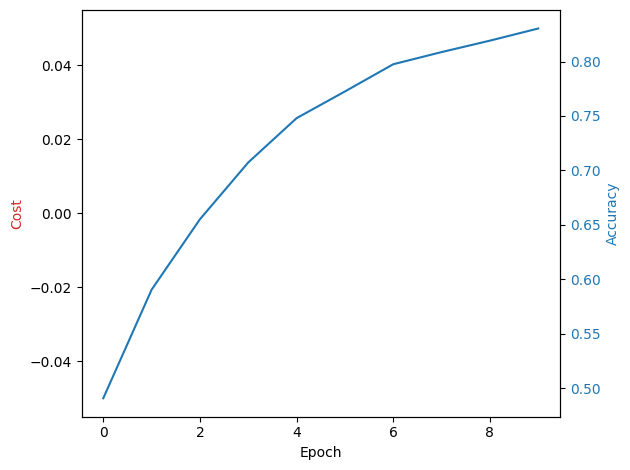

In [29]:
plot(cum_loss_list,acc_epoch)

In [30]:
evaluate(test_dataloader)

0.8165789473684211

In [31]:
# Get the first batch from the validation data
batch = next(iter(valid_dataloader))

# Extract the text and offsets from the batch
label, text, offsets = batch

# Send the data to the device (GPU if available)
text = text.to(device)
offsets = offsets.to(device)

# Get the embeddings bag output for the batch
embedded = model.embedding(text, offsets)

# Convert the embeddings tensor to a numpy array
embeddings_numpy = embedded.detach().cpu().numpy()

# Perform t-SNE on the embeddings to reduce their dimensionality to 3D.
X_embedded_3d = TSNE(n_components=3).fit_transform(embeddings_numpy)

# Create a 3D scatter plot using Plotly
trace = go.Scatter3d(
    x=X_embedded_3d[:, 0],
    y=X_embedded_3d[:, 1],
    z=X_embedded_3d[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=label.numpy(),  # Use label information for color
        colorscale='Viridis',  # Choose a colorscale
        opacity=0.8
    )
)

layout = go.Layout(title="3D t-SNE Visualization of Embeddings",
                   scene=dict(xaxis_title='Dimension 1',
                              yaxis_title='Dimension 2',
                              zaxis_title='Dimension 3'))

fig = go.Figure(data=[trace], layout=layout)
fig.show()

In [32]:
article="""Canada navigated a stiff test against the Republic of Ireland on a rain soaked evening in Perth, coming from behind to claim a vital 2-1 victory at the Women’s World Cup.
Katie McCabe opened the scoring with an incredible Olimpico goal – scoring straight from a corner kick – as her corner flew straight over the despairing Canada goalkeeper Kailen Sheridan at Perth Rectangular Stadium in Australia.
Just when Ireland thought it had safely navigated itself to half time with a lead, Megan Connolly failed to get a clean connection on a clearance with the resulting contact squirming into her own net to level the score.
Minutes into the second half, Adriana Leon completed the turnaround for the Olympic champion, slotting home from the edge of the area to seal the three points."""

In [35]:
result = predict(article, text_pipeline)

markdown_content = f'''
<div style="background-color: black; padding: 10px;">
    <h3>{article}</h3>
    <h4>The category of the news article: {result}</h4>
</div>
'''

md(markdown_content)


<div style="background-color: black; padding: 10px;">
    <h3>Canada navigated a stiff test against the Republic of Ireland on a rain soaked evening in Perth, coming from behind to claim a vital 2-1 victory at the Women’s World Cup.
Katie McCabe opened the scoring with an incredible Olimpico goal – scoring straight from a corner kick – as her corner flew straight over the despairing Canada goalkeeper Kailen Sheridan at Perth Rectangular Stadium in Australia.
Just when Ireland thought it had safely navigated itself to half time with a lead, Megan Connolly failed to get a clean connection on a clearance with the resulting contact squirming into her own net to level the score.
Minutes into the second half, Adriana Leon completed the turnaround for the Olympic champion, slotting home from the edge of the area to seal the three points.</h3>
    <h4>The category of the news article: Sports</h4>
</div>


In [36]:
model.load_state_dict(torch.load('my_model.pth'))
model.eval()

TextClassificationModel(
  (embedding): EmbeddingBag(95811, 64, mode='mean')
  (fc): Linear(in_features=64, out_features=4, bias=True)
)

In [42]:
new_articles = [
    "International talks have made significant headway with the signing of a climate accord that commits countries to reduce emissions by 40% over the next two decades. World leaders expressed optimism at the conclusion of the summit.",
    "In a stunning upset, the underdog team won the national title, beating the favorites in a match that featured an incredible comeback and a last-minute goal that sealed their victory in front of a record crowd.",
    "Market analysts are optimistic as the tech startup's stock prices soared after the announcement of their latest product, which promises to revolutionize how we interact with smart devices.",
    "A recent study published in a leading scientific journal suggests that a new drug has shown promise in the treatment of Alzheimer's disease, outperforming current leading medications in early clinical trials.",
    "Diplomatic relations have taken a positive turn with the recent peace talks that aim to end decades of conflict. The ceasefire agreement has been welcomed by the international community.",
    "Economic indicators show a sharp rebound in manufacturing, with the automobile industry leading the charge. Analysts predict this surge will result in significant job creation over the next year.",
    "Researchers at the university's astrophysics department have discovered a potentially habitable exoplanet. The planet, which lies in a nearby star system, has conditions that could support liquid water and, possibly, life.",
    "The sports world is in shock as a legendary player announces their retirement. Over an illustrious 20-year career, the athlete has amassed numerous records and is regarded as one of the greatest to ever play the game.",
    "A multinational corporation has announced a major investment in renewable energy. The initiative includes the construction of new wind farms and solar panels that will power hundreds of thousands of homes.",
    "Climate scientists warn that the melting of the polar ice caps has been accelerating at an alarming rate, raising sea levels and threatening coastal cities worldwide with increased flooding risks."
]

In [48]:
contents = []
for article in new_articles:
    result = predict(article, text_pipeline)
    contents.append((article, result))

contents

[('International talks have made significant headway with the signing of a climate accord that commits countries to reduce emissions by 40% over the next two decades. World leaders expressed optimism at the conclusion of the summit.',
  'Sci/Tec'),
 ('In a stunning upset, the underdog team won the national title, beating the favorites in a match that featured an incredible comeback and a last-minute goal that sealed their victory in front of a record crowd.',
  'Sports'),
 ("Market analysts are optimistic as the tech startup's stock prices soared after the announcement of their latest product, which promises to revolutionize how we interact with smart devices.",
  'Business'),
 ("A recent study published in a leading scientific journal suggests that a new drug has shown promise in the treatment of Alzheimer's disease, outperforming current leading medications in early clinical trials.",
  'Sci/Tec'),
 ('Diplomatic relations have taken a positive turn with the recent peace talks that ai

In [51]:
for i, article in enumerate(new_articles, start=1):
    result = predict(article, text_pipeline)
    print(f"Article {i} - Category: {result}")

Article 1 - Category: Sci/Tec
Article 2 - Category: Sports
Article 3 - Category: Business
Article 4 - Category: Sci/Tec
Article 5 - Category: World
Article 6 - Category: Business
Article 7 - Category: Sci/Tec
Article 8 - Category: Sports
Article 9 - Category: Sci/Tec
Article 10 - Category: Sci/Tec
